In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from tqdm import tqdm 
import numpy as np 
from sklearn.decomposition import PCA 
from sklearn.decomposition import KernelPCA
from scipy.sparse.linalg import svds
from matplotlib.colors import LinearSegmentedColormap
import random 

In [2]:
# extract raw data and epoch it 
raw = mne.io.read_raw_eeglab('sep_uwgr_prepro.set', preload=False)
events, event_id = mne.events_from_annotations(raw)

tmin = -0.05
tmax = 0.22

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=None, preload=False)

Reading /data/hu_kamm/eeg_llm/sep_uwgr_prepro.fdt


/tmp/ipykernel_1768416/2354897670.py:1: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_raw_eeglab('sep_uwgr_prepro.set', preload=False)


Used Annotations descriptions: [np.str_('1')]
Not setting metadata
6038 matching events found
No baseline correction applied
0 projection items activated


In [3]:
# get data and average data 
data = epochs.get_data()
avg_data = epochs.average().data

Loading data for 6038 events and 554 original time points ...
0 bad epochs dropped


In [4]:
# apply SVD on average data 
U, S, Vh = np.linalg.svd(avg_data, full_matrices=True)

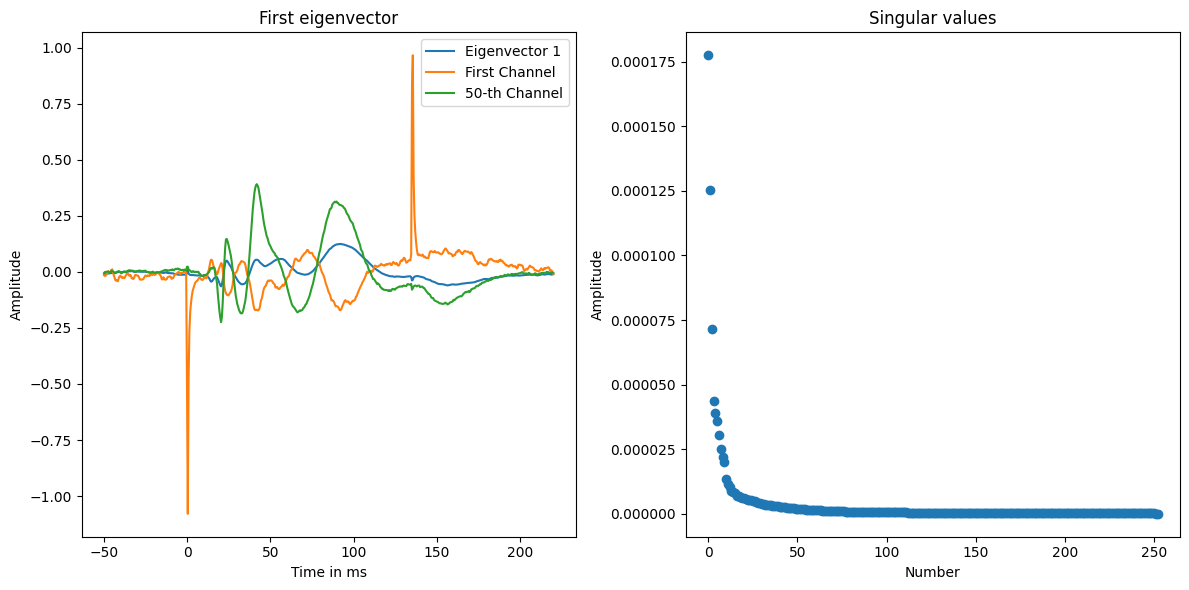

In [8]:
timepoints = np.linspace(tmin, tmax, 554)

# Create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first eigenvector alongside with some channels 
eig_n = 0

ax1.plot(timepoints * 1000, Vh[eig_n], label=f'Eigenvector {eig_n+1}')
ax1.plot(timepoints * 1000, avg_data[0] * 100000, label=f'First Channel')
ax1.plot(timepoints * 1000, avg_data[49] * 100000, label=f'50-th Channel')
ax1.set_title(f'First eigenvector')
ax1.set_xlabel('Time in ms')
ax1.set_ylabel('Amplitude')
ax1.legend()

# Plot the singular values 
ax2.plot(S.T,'o')
ax2.set_title('Singular values')
ax2.set_xlabel('Number')
ax2.set_ylabel('Amplitude')

# Display the plots
plt.tight_layout()
plt.show()

In [9]:
# project the data onto the first two eigenvectors of the U-matrix 
proj_U1 = np.dot(U.T[0], data)
proj_U2 = np.dot(U.T[1], data)

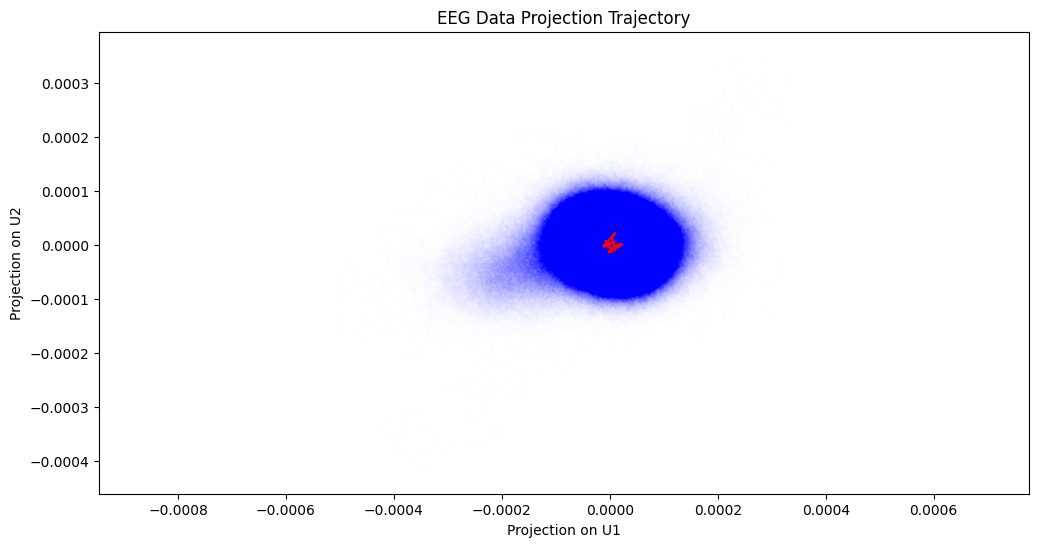

In [10]:
# Plot the trajectory (proj_U1 vs proj_U2) per trial 
plt.figure(figsize=(12, 6))
for trial_U1, trial_U2 in zip(proj_U1, proj_U2):
    plt.plot(trial_U1, trial_U2, alpha=0.002, color='blue') 

# plot the trajectory of the first two eigenvectors of the average data 
plt.plot(S[0]*Vh[0], S[1]*Vh[1], color='red')

# Add labels and title
plt.xlabel('Projection on U1')
plt.ylabel('Projection on U2')
plt.title('EEG Data Projection Trajectory')

# Display the plot
plt.axis('equal')
plt.show()

In [13]:
def explained_variance_ratio(singular_values, total_samples):
    # Calculate the total variance in the dataset
    total_variance = np.sum(singular_values**2) / (total_samples - 1)
    
    # Calculate the explained variance for each component
    explained_variances = (singular_values**2) / (total_samples - 1) / total_variance
    
    return explained_variances

# get epochs, channels and timepoints and create list to store principle components for each epoch 
epochs, channels, timepoints = data.shape
first_two_principle_components_list = []
sing_vals_list = []
explained_vars_list= []
left_eigenvectors_list = []


for epoch in tqdm(range(epochs)):
    # get data for each epoch 
    epoch_data = data[epoch, :, :]

    # apply PCA on each epoch 
    pca_per_trial =  PCA()
    X_transformed = pca_per_trial.fit_transform(epoch_data)

    # get first two principle components, singular values, left eigenvectors and compute explained variance ratio for each trial  
    first_two_principal_components_per_trial = pca_per_trial.components_[:2]
    first_two_principle_components_list.append(first_two_principal_components_per_trial)
    sing_vals_per_trial = pca_per_trial.singular_values_
    sing_vals_list.append(sing_vals_per_trial)
    explained_var_trial = explained_variance_ratio(sing_vals_per_trial, sing_vals_per_trial.shape[0])
    explained_vars_list.append(explained_var_trial)
    first_two_left_eigenvectors_per_trial = (X_transformed / sing_vals_per_trial)[:2] 
    left_eigenvectors_list.append(first_two_left_eigenvectors_per_trial)


# get mean over all epochs for principle components, singular values, left eigenvectors and explained variance 
avg_explained_var = np.mean(explained_vars_list, axis=0)
avg_V = np.mean(first_two_principle_components_list, axis=0)
avg_S = np.mean(sing_vals_list, axis=0)
avg_U = np.mean(left_eigenvectors_list, axis=0)

  0%|          | 3/6038 [00:29<16:40:25,  9.95s/it]


KeyboardInterrupt: 

In [185]:
explained_vars = np.array(explained_vars)

In [187]:
explained_vars.shape

(6038, 253)

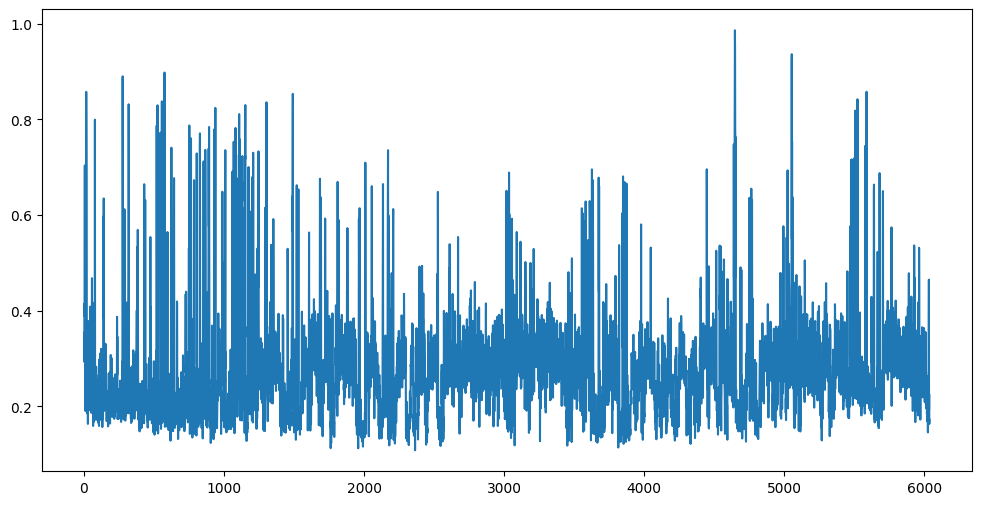

In [188]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(explained_vars[:, 0])

plt.show()

In [79]:
# apply PCA to average data 
pca = PCA(n_components=2)
pca.fit(avg_data)

first_two_comp = pca.components_

In [169]:
avg_S.shape

(253,)

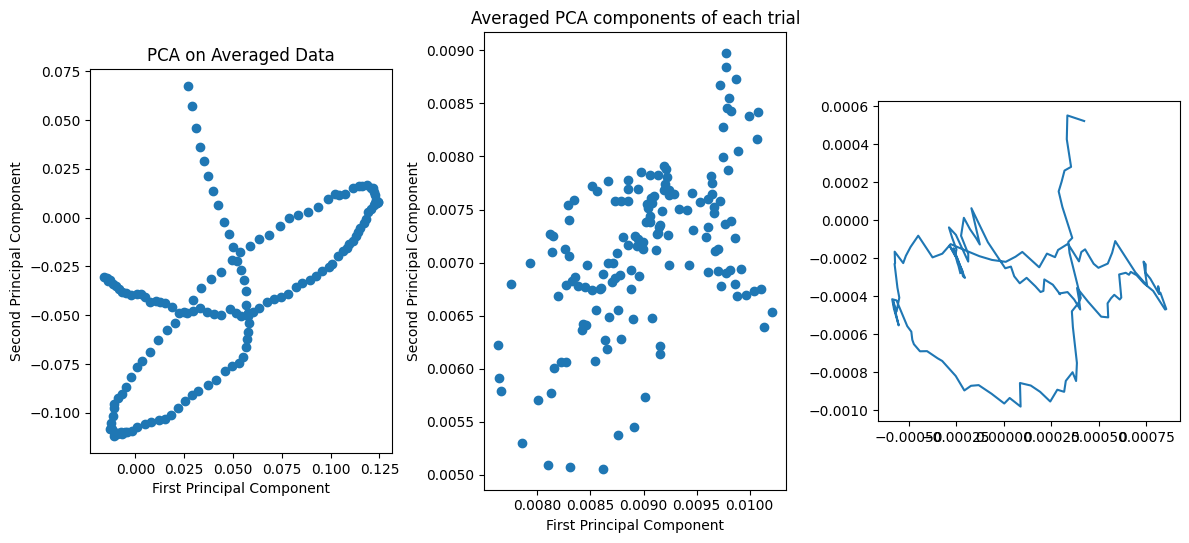

In [199]:
# create figure with two subplots 

t1 = 200
t2 = 350

fig, axes = plt.subplots(1, 3, figsize=(12,6))

# first subplot of eigenvectors of averaged data 
axes[0].scatter(first_two_comp[0][t1:t2], first_two_comp[1][t1:t2])
axes[0].set_title('PCA on Averaged Data')
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
axes[0].set_aspect('equal')

# second subplot of averaged eigenvectors of each trial 
axes[1].scatter(avg_V[0][t1:t2], avg_V[1][t1:t2])
axes[1].set_title('Averaged PCA components of each trial')
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Second Principal Component')
axes[1].set_aspect('equal')

# 
axes[2].plot((np.linalg.inv(np.diag(avg_S[:2])) @ np.dot(avg_U, avg_data))[0][t1:t2],(np.linalg.inv(np.diag(avg_S[:2])) @ np.dot(avg_U, avg_data))[1][t1:t2])
axes[2].set_aspect('equal')


plt.tight_layout()
plt.show()

In [159]:
proj_U1_avg = np.dot(avg_U[0].T, data)
proj_U2_avg = np.dot(avg_U[1].T, data)

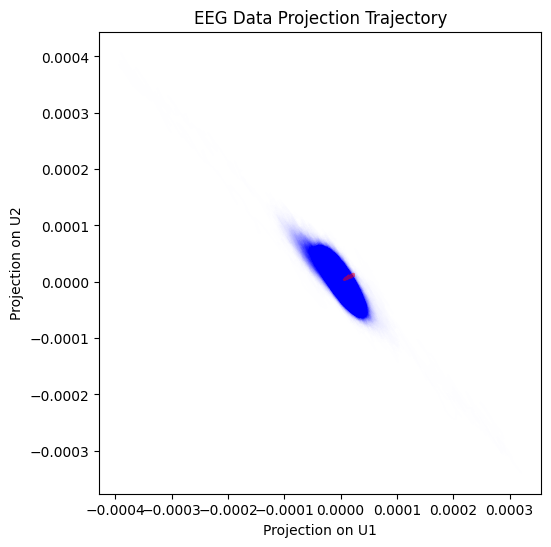

In [161]:
# Plot the trajectory (proj_U1 vs proj_U2)
plt.figure(figsize=(12, 6))
for trial_U1, trial_U2 in zip(proj_U1_avg, proj_U2_avg):
    plt.plot(trial_U1, trial_U2, alpha=0.002, color='blue')  # Each trial

plt.plot(avg_S[0]*avg_V[0], avg_S[1]*avg_V[1], alpha=0.5, color='red')

# Add labels and title
plt.xlabel('Projection on U1')
plt.ylabel('Projection on U2')
plt.title('EEG Data Projection Trajectory')

# Show the plot
plt.gca().set_aspect('equal')
plt.show()

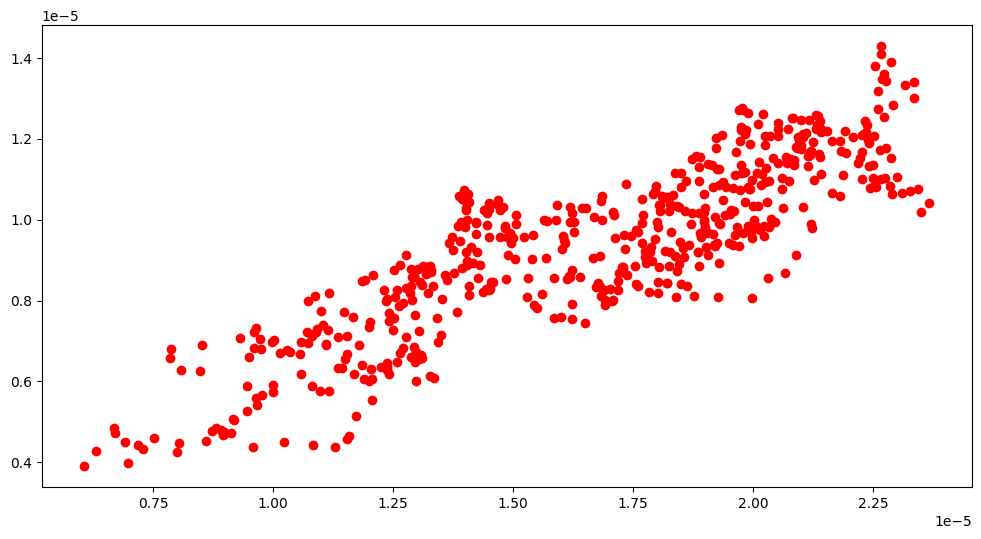

In [164]:
# plot only trajectory 
plt.figure(figsize=(12, 6))
plt.scatter(avg_V[0] * avg_S[0], avg_V[1] * avg_S[1], color='red')
plt.show()

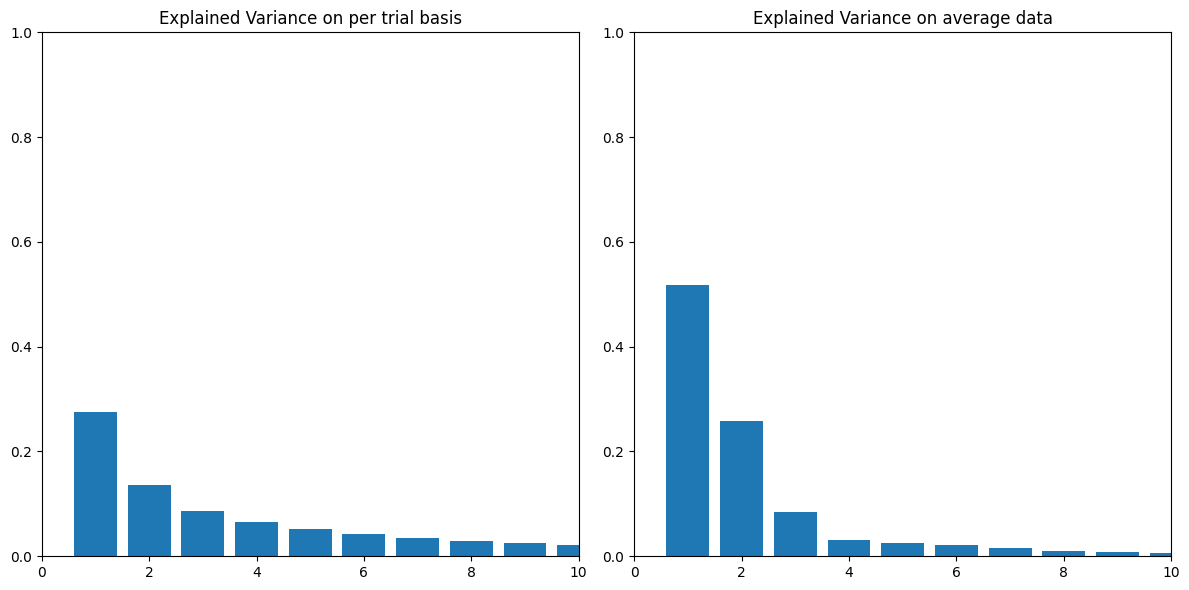

np.float64(0.49902316531596413)

In [212]:
# get explained variance of linear PCA on a per trial basis and on average data 
def explained_variance_ratio(singular_values, total_samples):
    # Calculate the total variance in the dataset
    total_variance = np.sum(singular_values**2) / (total_samples - 1)
    
    # Calculate the explained variance for each component
    explained_variances = (singular_values**2) / (total_samples - 1) / total_variance
    
    return explained_variances

explaned_var_ratio_avg = explained_variance_ratio(S, S.shape[0])
fig, axes = plt.subplots(1, 2, figsize=(12,6))

# plot explained variance on per trial basis 
axes[0].bar(range(1, len(avg_explained_var) + 1), avg_explained_var, align='center')
axes[0].set_ylim(0, 1)
axes[0].set_xlim(0,10)
axes[0].set_title('Explained Variance on per trial basis')

# plot explained variance of averaged data 
axes[1].bar(range(1, len(explaned_var_ratio_avg) + 1), explaned_var_ratio_avg, align='center')
axes[1].set_ylim(0, 1)
axes[1].set_xlim(0,10)
axes[1].set_title('Explained Variance on average data')

plt.tight_layout()
plt.show()

np.sum(avg_explained_var[:3])

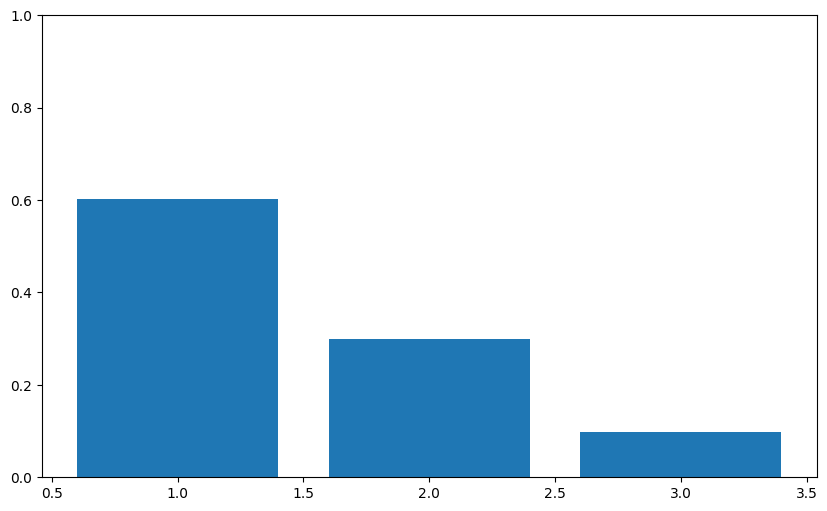

In [18]:
# get the importance of eigenvalues for KernelPCA, note that the explained variance ratio cannot be computed explitely, since the kernel matrix does not correspond to the covariance matrix 
kpca = KernelPCA(kernel='rbf', n_components=3)
kpca.fit(avg_data.T)

lambdas = kpca.eigenvalues_
explained_variance_ratio = lambdas / np.sum(lambdas)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, align='center')
plt.ylim(0, 1)
plt.show()

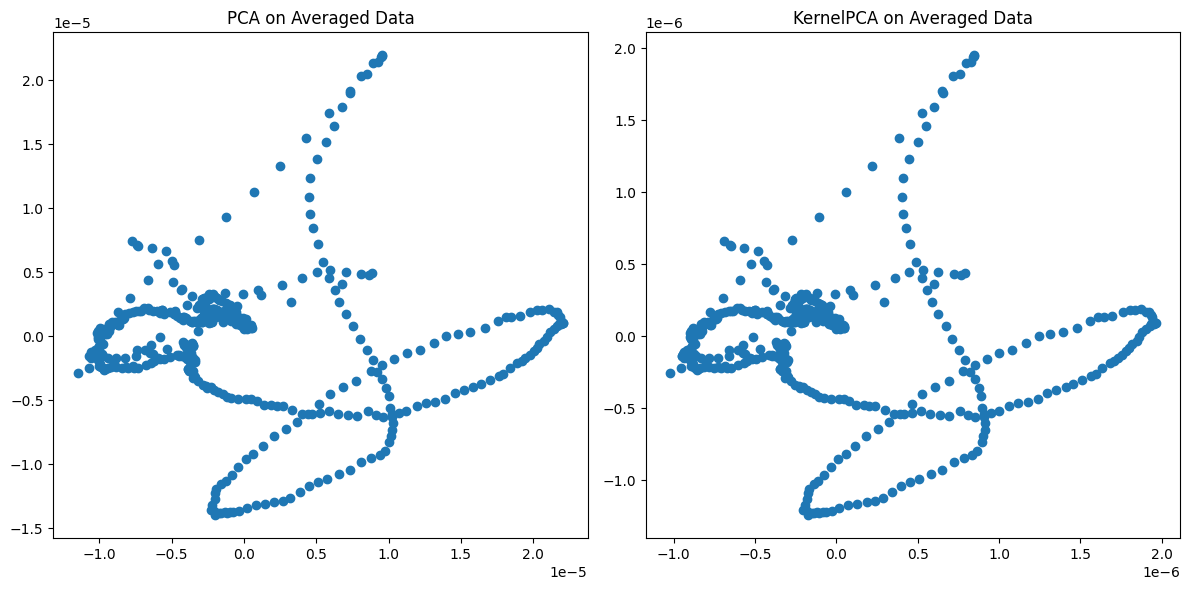

In [19]:
# This may indicate that KernelPCA works a little bit better when downprojecting the data, let's examine this 
pca_transf = pca.fit_transform(avg_data.T)
kpca_transf = kpca.fit_transform(avg_data.T)

fig, axes = plt.subplots(1, 2, figsize=(12,6))

axes[0].scatter(pca_transf[:, 0], pca_transf[:, 1])
axes[0].set_title('PCA on Averaged Data')

axes[1].scatter(kpca_transf[:, 0], kpca_transf[:, 1])
axes[1].set_title('KernelPCA on Averaged Data')

plt.tight_layout()
plt.show()

In [4]:
# As can be seen KernelPCA did not accomplish anything, which Linear PCA was not already capable of doing
epochs, channels, timepoints = data.shape
first_eig_vec_of_each_epoch = []


for epoch in tqdm(range(epochs)):
    # get data for each epoch 
    epoch_data = data[epoch, :, :]

    # apply PCA 
    pca_per_trial =  PCA(n_components=2)
    X_transformed = pca_per_trial.fit(epoch_data)

    # get first two principle components
    eig_vec = pca_per_trial.components_
    first_eig_vec_of_each_epoch.append(eig_vec)


# store all principle components in an array
first_eig_vec_of_each_epoch = np.array(first_eig_vec_of_each_epoch)

100%|██████████| 6038/6038 [00:11<00:00, 513.49it/s]


In [168]:
# compute similarity matrices, meaning each pairwise dot product of the eigenvectors of each epoch to understand the differences in dynamics of each epoch 
first_similarity_matrix = np.abs(first_eig_vec_of_each_epoch[:, 0, :] @  first_eig_vec_of_each_epoch[:, 0, :].T)
second_similarity_matrix = np.abs(first_eig_vec_of_each_epoch[:, 1, :] @  first_eig_vec_of_each_epoch[:, 1, :].T)
average_similarity_matrix = np.abs(first_eig_vec_of_each_epoch[:, 1, :] @  first_two_comp[0].T)
average_similarity_matrix = np.tile(average_similarity_matrix, (len(average_similarity_matrix), 1))

In [171]:
np.shape(average_similarity_matrix)

(6038, 6038)

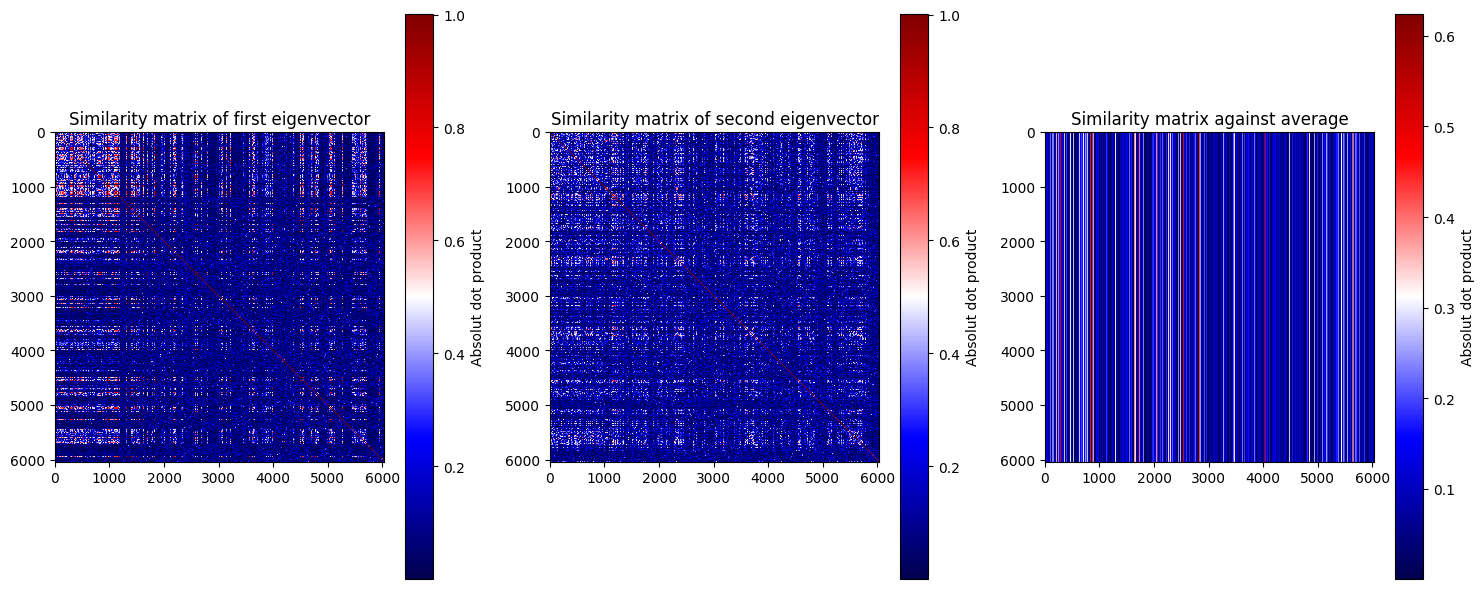

In [173]:
# plot the similarity matrices for the first two principal components 
fig, axes = plt.subplots(1, 3, figsize=(15,6))


im_1 = axes[0].imshow(first_similarity_matrix, cmap='seismic', interpolation='nearest')
cbar_1 = fig.colorbar(im_1, ax=axes[0])
cbar_1.set_label('Absolut dot product')
axes[0].set_title('Similarity matrix of first eigenvector')

im_2 = axes[1].imshow(second_similarity_matrix, cmap='seismic', interpolation='nearest')
cbar_2 = fig.colorbar(im_2, ax=axes[1])
cbar_2.set_label('Absolut dot product')
axes[1].set_title('Similarity matrix of second eigenvector')

im_3 = axes[2].imshow(average_similarity_matrix, cmap='seismic', interpolation='nearest')
cbar_3 = fig.colorbar(im_3, ax=axes[2])
cbar_3.set_label('Absolut dot product')
axes[2].set_title('Similarity matrix against average')

plt.tight_layout()
plt.show()

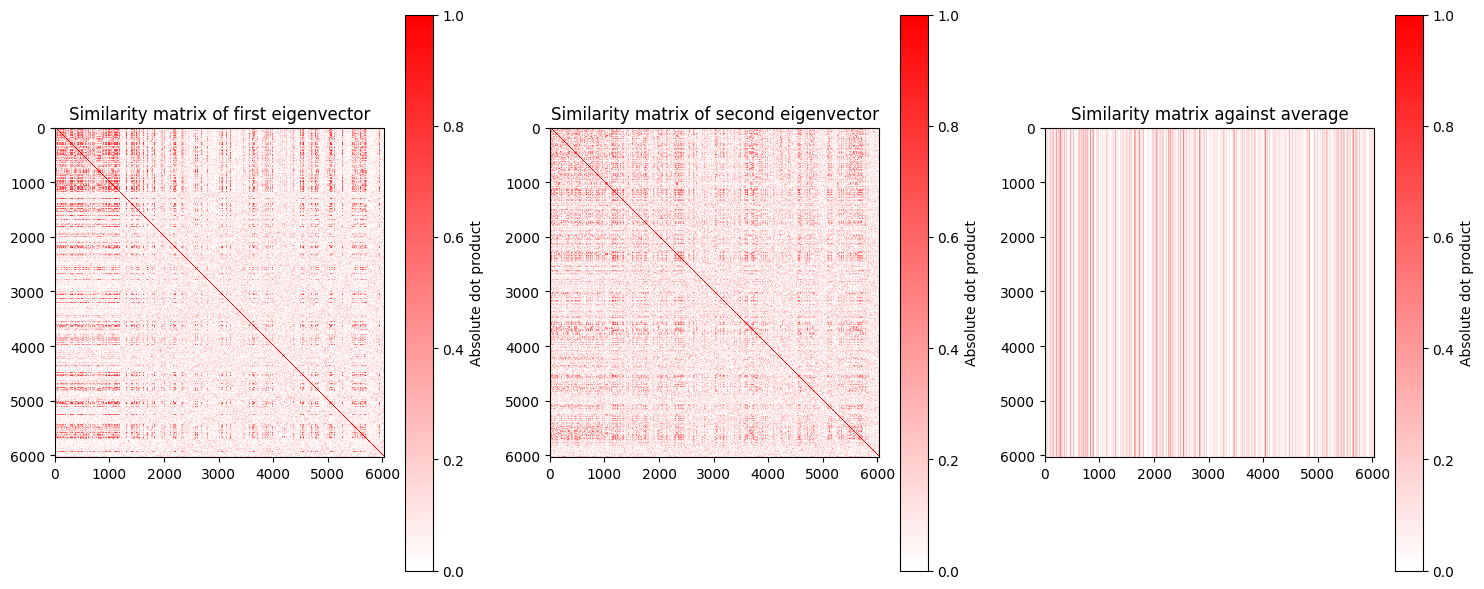

In [174]:
# Create a custom colormap to enhance visualizing the eigenvectors with high similarity 
colors = [(1, 1, 1), (1, 0, 0)]  
n_bins = 100 
cmap_name = 'white_to_red'
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)


fig, axes = plt.subplots(1, 3, figsize=(15, 6))

im_1 = axes[0].imshow(first_similarity_matrix, cmap=custom_cmap, interpolation='nearest', vmin=0, vmax=1)
cbar_1 = fig.colorbar(im_1, ax=axes[0])
cbar_1.set_label('Absolute dot product')
axes[0].set_title('Similarity matrix of first eigenvector')

im_2 = axes[1].imshow(second_similarity_matrix, cmap=custom_cmap, interpolation='nearest', vmin=0, vmax=1)
cbar_2 = fig.colorbar(im_2, ax=axes[1])
cbar_2.set_label('Absolute dot product')
axes[1].set_title('Similarity matrix of second eigenvector')

im_3 = axes[2].imshow(average_similarity_matrix, cmap=custom_cmap, interpolation='nearest', vmin=0, vmax=1)
cbar_3 = fig.colorbar(im_3, ax=axes[2])
cbar_3.set_label('Absolute dot product')
axes[2].set_title('Similarity matrix against average')

plt.tight_layout()
plt.show()


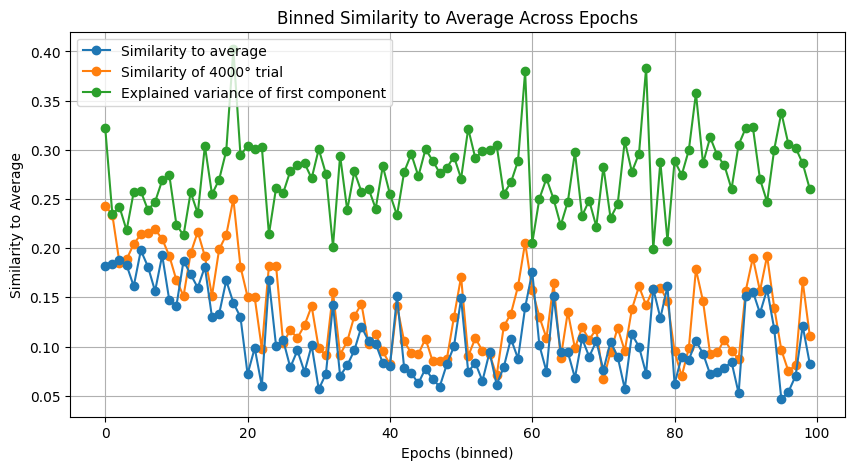

array([0.18151451, 0.18354732, 0.18833884, 0.18278491, 0.16129882,
       0.19780093, 0.18123848, 0.15632139, 0.19283743, 0.14702708,
       0.14144165, 0.18719192, 0.17338774, 0.15984013, 0.18112387,
       0.12965513, 0.13314834, 0.16715857, 0.14450173, 0.12986102,
       0.07187158, 0.09848901, 0.05978065, 0.16729412, 0.10083485,
       0.10650874, 0.07876423, 0.09605128, 0.07412948, 0.10110738,
       0.05668295, 0.07204298, 0.14268043, 0.07015186, 0.08085188,
       0.09609286, 0.1203375 , 0.10538371, 0.10298824, 0.08312228,
       0.07980679, 0.15122977, 0.07814892, 0.07273467, 0.06271827,
       0.07758289, 0.06655533, 0.05932701, 0.08209484, 0.10009458,
       0.14898649, 0.07434382, 0.08335173, 0.06502061, 0.09433506,
       0.06125714, 0.07912307, 0.10794012, 0.08776943, 0.13973276,
       0.17593772, 0.1013832 , 0.07454243, 0.15110325, 0.09445344,
       0.09422631, 0.06818187, 0.10822943, 0.08965415, 0.10556866,
       0.07601126, 0.10493521, 0.08969971, 0.05703343, 0.11232

In [216]:
trial = 4000

# Compute similarity to average
similarity_to_avg = np.abs(first_eig_vec_of_each_epoch[:, 0, :] @  first_two_comp[0].T)

# Binning the plot data
n_bins = 100  # You can change this to any desired bin size
# Split the similarity_to_avg array into n_bins
bins_similarity_to_avg = np.array_split(similarity_to_avg, n_bins)
bins_first_similarity_matrix = np.array_split(first_similarity_matrix[trial], n_bins)
bins_explained_vars = np.array_split(explained_vars[:,0], n_bins)

# Calculate the mean of each bin
binned_similarity_to_avg = np.array([np.mean(bin) for bin in bins_similarity_to_avg])
binned_first_similarity_matrix = np.array([np.mean(bin) for bin in bins_first_similarity_matrix])
binned_explained_vars = np.array([np.mean(bin) for bin in bins_explained_vars])


# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(0, n_bins), binned_similarity_to_avg, marker='o', zorder=3, label='Similarity to average')
plt.plot(binned_first_similarity_matrix, marker='o', zorder=2, label='Similarity of ' + str(trial) + '° trial')
plt.plot(binned_explained_vars, marker='o', zorder=3, label='Explained variance of first component')
plt.xlabel('Epochs (binned)')
plt.ylabel('Similarity to Average')
plt.title('Binned Similarity to Average Across Epochs')
plt.grid(True)
plt.legend()
plt.show()

# Outputting the binned values for inspection
binned_similarity_to_avg

In [134]:
# thresholding the similarities of the eigenvectors 
threshold = 1 / np.sqrt(2)
num_epochs = 500
count = np.sum(first_similarity_matrix > threshold, axis=1)
indices = np.where(count >= num_epochs)[0]

In [126]:
indices = random.sample(range(0, 6038), 249)

In [135]:
indices.shape

(51,)

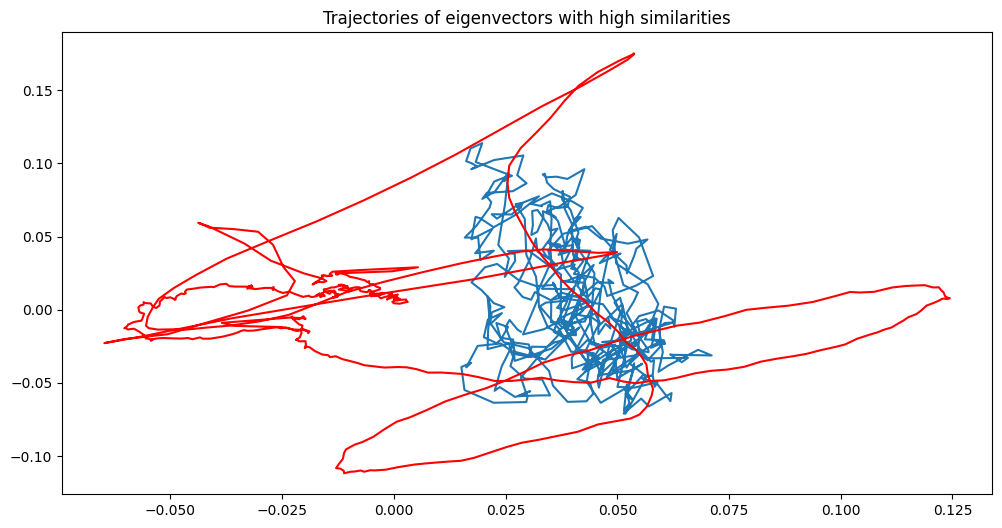

In [224]:
first_eig_vecs_high_sim = first_eig_vec_of_each_epoch[indices, 0, :]
second_eig_vecs_high_sim = first_eig_vec_of_each_epoch[indices, 1, :]

fig, ax = plt.subplots(figsize=(12,6))

first_eigvecshs_avg = np.mean(first_eig_vecs_high_sim, axis=0)
second_eigvecshs_avg = np.mean(second_eig_vecs_high_sim, axis=0)

# plot the first two eigenvectors with high similarities to other epochs 
#for i in range(len(indices)):
#    ax.plot(first_eig_vecs_high_sim[i], second_eig_vecs_high_sim[i], alpha=0.1)
#    ax.set_aspect('equal')
j = 4
ax.plot(first_eig_vecs_high_sim[j], second_eig_vecs_high_sim[j], alpha=1)
ax.plot(first_two_comp[0], first_two_comp[1], color='red')
#ax.plot(first_eigvecshs_avg, second_eigvecshs_avg, color='blue')
ax.set_title('Trajectories of eigenvectors with high similarities')


plt.show()

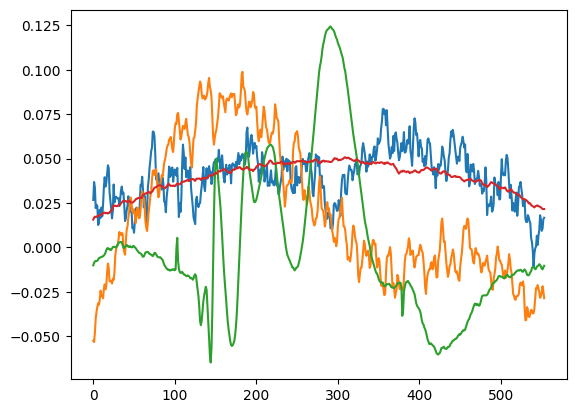

In [137]:
plt.plot(first_eig_vecs_high_sim[0])
plt.plot(first_eig_vec_of_each_epoch[1,0])
plt.plot(first_two_comp[0])
plt.plot(first_eigvecshs_avg)